In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# HMM library
from hmmlearn.hmm import GaussianHMM

# Data fetching
import yfinance as yf
from scipy import stats
import statsmodels.api as sm

In [5]:
# Plotting style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Disable warnings (optional)
import warnings
warnings.filterwarnings('ignore')

# Load data

In [6]:
# Download S&P 500 historical data
sp500 = yf.download('^GSPC', start='2000-01-01', end='2025-07-01')
sp500['LogReturn'] = np.log(sp500['Close']).diff()
sp500.dropna(inplace=True)

sp500.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,LogReturn
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000,-0.039099
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000,0.001920
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000,0.000955
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000,0.026730
2000-01-10,1457.599976,1464.359985,1441.469971,1441.469971,1064800000,0.011128


Using log returns because:
* Log returns are additive over time: The sum of daily log returns over 𝑛 days equals the total log return over that period.
This property simplifies modelling cumulative returns.
* Better for Statistical Modelling: Log returns often approximate a normal distribution more closely than simple returns.
* Handle Compounding Correctly in Models: They naturally account for the effect of compounding in continuous time.

# Data exploration

S&P 500 Close Price Summary:
Ticker        ^GSPC
count   6410.000000
mean    2182.539603
std     1331.744599
min      676.530029
25%     1205.374969
50%     1507.784973
75%     2817.850098
max     6204.950195

S&P 500 Daily Log Return Summary:
count    6410.000000
mean        0.000226
std         0.012299
min        -0.127652
25%        -0.004810
50%         0.000628
75%         0.005918
max         0.109572
Name: LogReturn, dtype: float64


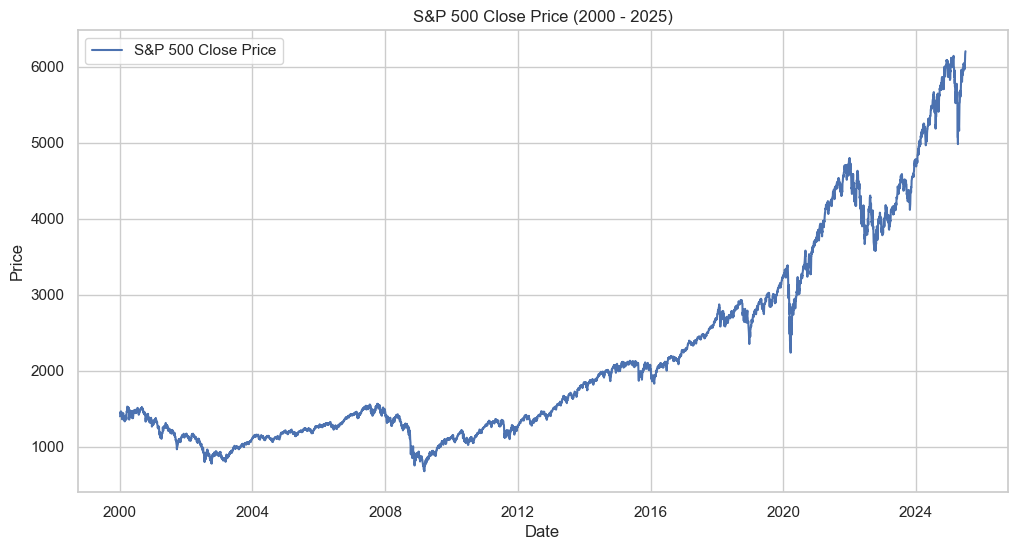

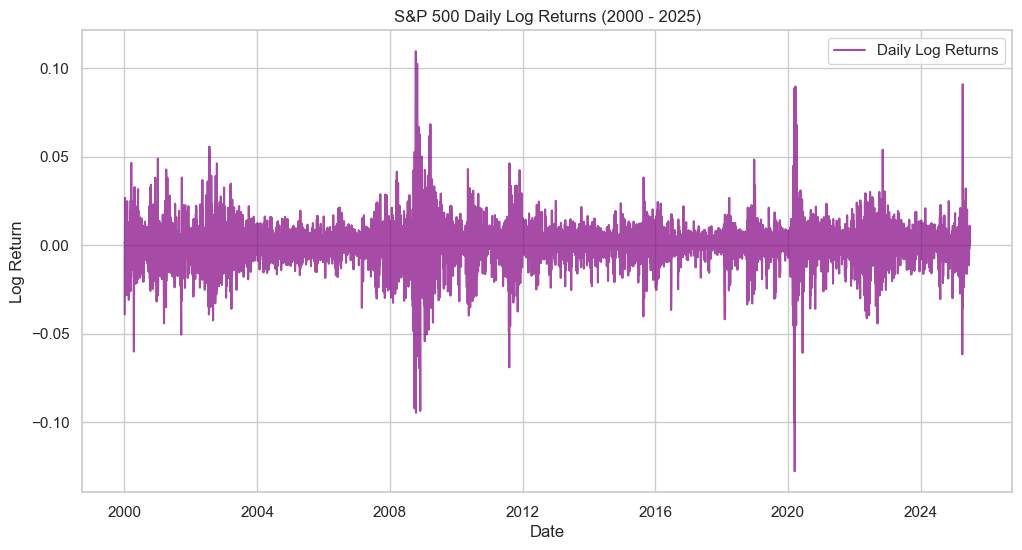

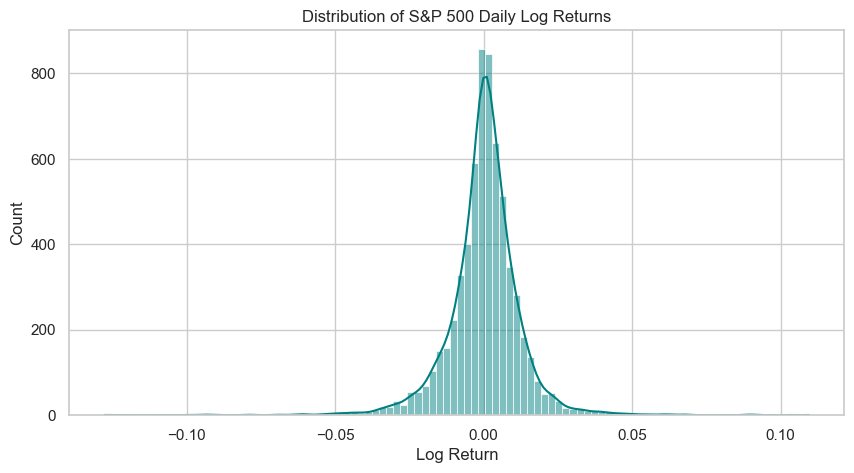

In [7]:
# Summary statistics for prices and log returns
print("S&P 500 Close Price Summary:")
print(sp500['Close'].describe())

print("\nS&P 500 Daily Log Return Summary:")
print(sp500['LogReturn'].describe())

# --- Visualising the Close Price ---
plt.figure(figsize=(12, 6))
plt.plot(sp500['Close'], label='S&P 500 Close Price')
plt.title('S&P 500 Close Price (2000 - 2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualising the Log Returns ---
plt.figure(figsize=(12, 6))
plt.plot(sp500['LogReturn'], label='Daily Log Returns', color='purple', alpha=0.7)
plt.title('S&P 500 Daily Log Returns (2000 - 2025)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()

# --- Histogram of Log Returns ---
plt.figure(figsize=(10, 5))
sns.histplot(sp500['LogReturn'], bins=100, kde=True, color='teal')
plt.title('Distribution of S&P 500 Daily Log Returns')
plt.xlabel('Log Return')
plt.grid(True)
plt.show()


HMM assumes normally distributed observations within each state

* If your returns are strongly non-normal (e.g., heavy tails, skew), the Gaussian HMM may give misleading results

* You might consider using mixtures of Gaussians or t-distributed emissions

## Visual and Stats check for Normality

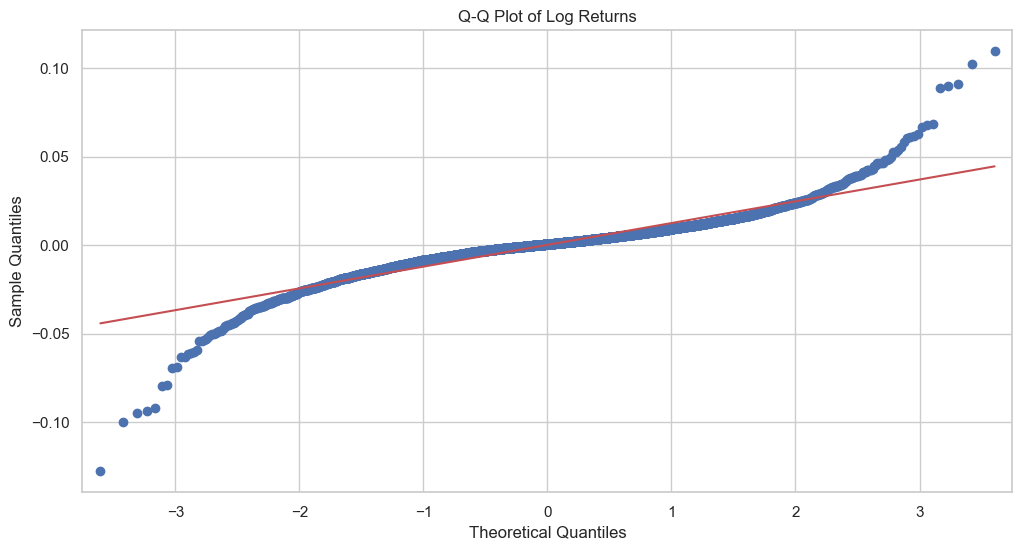

Shapiro-Wilk Test: W=0.8989, p=0.0000
Jarque-Bera Test: JB=29640.58, p=0.0000


In [8]:
# --- Histogram with KDE ---
# sns.histplot(sp500['LogReturn'], bins=100, kde=True, color='teal')
# plt.title('Distribution of Log Returns with KDE')
# plt.show()
# NOTE: see above

# --- Q-Q Plot ---
sm.qqplot(sp500['LogReturn'], line='s')
plt.title('Q-Q Plot of Log Returns')
plt.show()

# --- Shapiro-Wilk Test ---
shapiro_test = stats.shapiro(sp500['LogReturn'].sample(5000))  # Shapiro works best < 5000 samples
print(f"Shapiro-Wilk Test: W={shapiro_test.statistic:.4f}, p={shapiro_test.pvalue:.4f}")

# --- Jarque-Bera Test ---
jb_test = stats.jarque_bera(sp500['LogReturn'])
print(f"Jarque-Bera Test: JB={jb_test.statistic:.2f}, p={jb_test.pvalue:.4f}")

Tails on both end are heavier than normal. HMM may still give us reasonable results. If not, we should consider Mixture HMM or t-distr HMM.

# HMM Model

## 2-state model

What Is a 2-State Gaussian HMM?

You assume the market is always in one of two hidden states:
* State 1: e.g., Low Volatility Regime
* State 2: e.g., High Volatility Regime

The observed log returns are modeled as coming from a Gaussian (Normal) distribution,
with different mean and variance for each state.

The model estimates:

* Transition probabilities between states

* State-specific mean and variance of returns

* Probability of being in each state over time

In [9]:
seed = 1997

In [10]:
# --- Assumptions & Decisions ---
# We assume:
# - Daily log returns are emissions
# - 2 hidden regimes (e.g., low volatility, high volatility)
# - Gaussian emissions (mean & variance differ per state)
# - No explicit regime labels — unsupervised learning

# --- Preparing Data ---
returns = sp500['LogReturn'].values.reshape(-1, 1)  # hmmlearn expects 2D array

# --- Fitting the 2-State Gaussian HMM ---
hmm2 = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000, random_state=seed, tol=1e-3)
hmm2.fit(returns)

# --- Hidden States Inference ---
hidden_states_2 = hmm2.predict(returns)

# Check the fitted means and variances per state
for i in range(hmm2.n_components):
    print(f"State {i}: Mean = {hmm2.means_[i][0]:.5f}, Variance = {hmm2.covars_[i][0][0]:.5f}")

print(f"Final log-likelihood: {hmm2.score(returns):.2f}")

State 0: Mean = 0.00077, Variance = 0.00005
State 1: Mean = -0.00119, Variance = 0.00041
Final log-likelihood: 20414.45


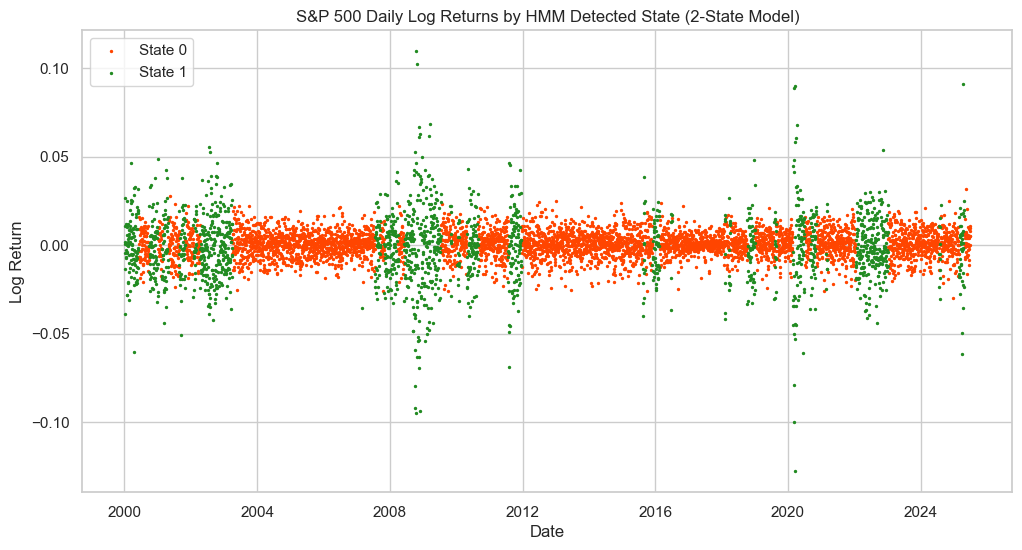

In [11]:
# Add states to DataFrame for plotting
sp500['HMM_2State'] = hidden_states_2

state_colors_2 = {0: 'orangered', 1: 'forestgreen'}

# --- Visualisation ---
plt.figure(figsize=(12, 6))
for state in range(hmm2.n_components):
    idx = sp500['HMM_2State'] == state
    plt.scatter(sp500.index[idx], sp500['LogReturn'][idx], s=2, color=state_colors_2[state], label=f'State {state}')
    
plt.title('S&P 500 Daily Log Returns by HMM Detected State (2-State Model)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()


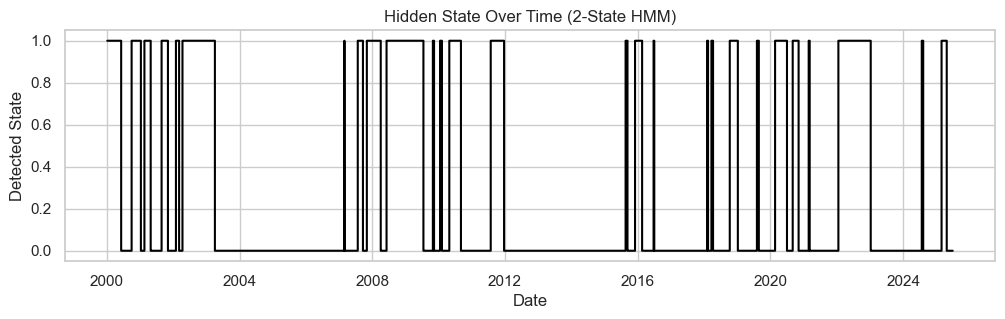

In [12]:
plt.figure(figsize=(12, 3))
plt.plot(sp500['HMM_2State'], drawstyle='steps-post', color='black')
plt.title('Hidden State Over Time (2-State HMM)')
plt.xlabel('Date')
plt.ylabel('Detected State')
plt.grid(True)
plt.show()


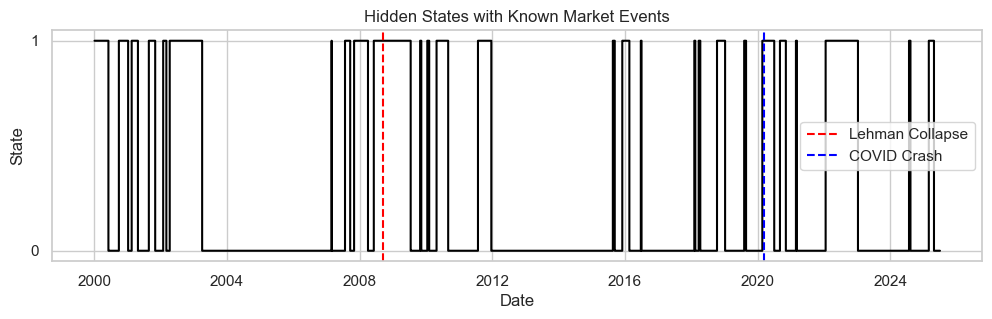

In [13]:
# Example with 2008 Financial Crisis and COVID Crash
plt.figure(figsize=(12, 3))
plt.plot(sp500['HMM_2State'], drawstyle='steps-post', color='black')
plt.axvline(pd.to_datetime('2008-09-15'), color='red', linestyle='--', label='Lehman Collapse')
plt.axvline(pd.to_datetime('2020-03-12'), color='blue', linestyle='--', label='COVID Crash')
plt.title('Hidden States with Known Market Events')
plt.xlabel('Date')
plt.ylabel('State')
plt.yticks([0, 1])
plt.legend()
plt.grid(True)
plt.show()


Transition Probability Matrix (2-State HMM):


,To State 0,To State 1
From State 0,0.9899,0.0101
From State 1,0.0268,0.9732


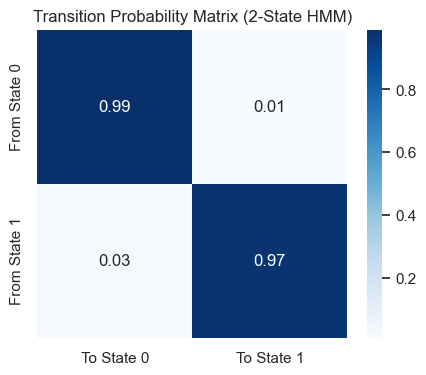

In [14]:
# --- Transition Matrix for 2-State Model ---
transition_matrix_2 = pd.DataFrame(hmm2.transmat_,
                                    columns=[f'To State {i}' for i in range(hmm2.n_components)],
                                    index=[f'From State {i}' for i in range(hmm2.n_components)])

print("Transition Probability Matrix (2-State HMM):")
display(transition_matrix_2.round(4))

# --- Heatmap ---
plt.figure(figsize=(5, 4))
sns.heatmap(transition_matrix_2, annot=True, fmt=".2f", cmap='Blues')
plt.title('Transition Probability Matrix (2-State HMM)')
plt.show()


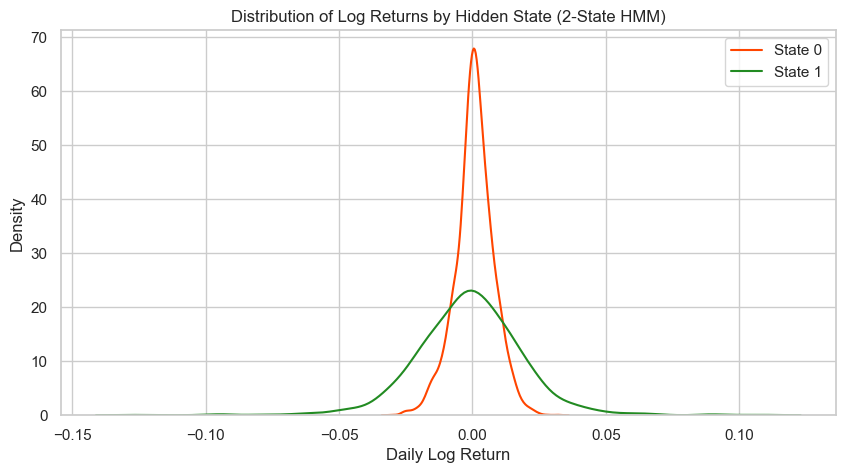

In [15]:
plt.figure(figsize=(10, 5))

for state in range(hmm2.n_components):
    sns.kdeplot(sp500['LogReturn'][sp500['HMM_2State'] == state], 
                label=f'State {state}', color=state_colors_2[state])

plt.title('Distribution of Log Returns by Hidden State (2-State HMM)')
plt.xlabel('Daily Log Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


## 3-state model

In [16]:
# --- Preparing Data (already done previously) ---
# returns = sp500['LogReturn'].values.reshape(-1, 1)

# --- Fitting the 3-State Gaussian HMM ---
hmm3 = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=seed, tol=1e-3)
hmm3.fit(returns)

# --- Hidden States Inference ---
hidden_states_3 = hmm3.predict(returns)

# Check the fitted means and variances per state
for i in range(hmm3.n_components):
    print(f"State {i}: Mean = {hmm3.means_[i][0]:.5f}, Variance = {hmm3.covars_[i][0][0]:.5f}")

print(f"Final log-likelihood (3-state): {hmm3.score(returns):.2f}")


Model is not converging.  Current: 20685.592909844898 is not greater than 20685.59445085981. Delta is -0.0015410149135277607


State 0: Mean = 0.00093, Variance = 0.00004
State 1: Mean = -0.00331, Variance = 0.00136
State 2: Mean = -0.00042, Variance = 0.00019
Final log-likelihood (3-state): 20685.59


State 0 captures turbulent/declining periods, higher variance and negative mean

State 1 reflects calm, positive-drift periods, bull markets or rallies

State 2 likely represents sideways or neutral regimes, moderate variance, low mean

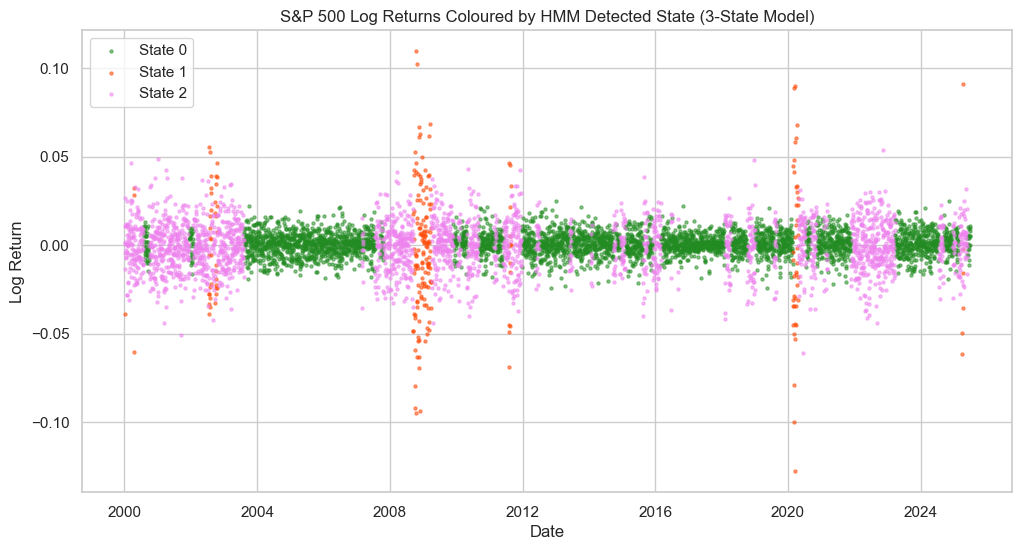

In [17]:
# Add detected states to DataFrame
sp500['HMM_3State'] = hidden_states_3

# Colour map for clarity with 3 states
state_colors_3 = {0: 'forestgreen', 1: 'orangered', 2: 'violet'}

plt.figure(figsize=(12, 6))
for state in range(hmm3.n_components):
    idx = sp500['HMM_3State'] == state
    plt.scatter(sp500.index[idx], sp500['LogReturn'][idx], 
                s=5, color=state_colors_3[state], label=f'State {state}', alpha=0.5)
    
plt.title('S&P 500 Log Returns Coloured by HMM Detected State (3-State Model)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()


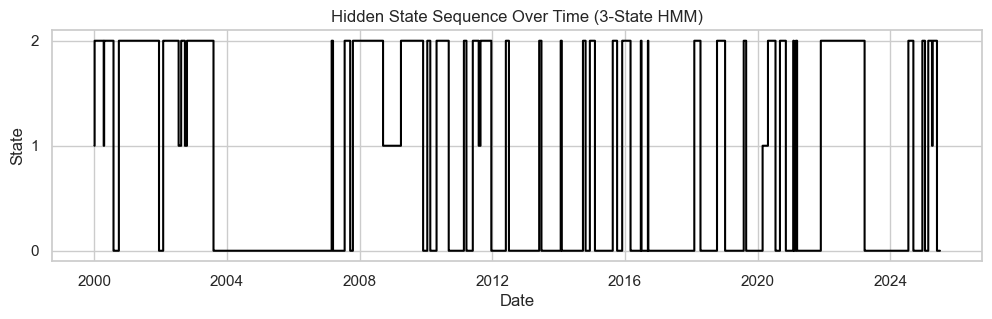

In [18]:
plt.figure(figsize=(12, 3))
plt.plot(sp500['HMM_3State'], drawstyle='steps-post', color='black')
plt.title('Hidden State Sequence Over Time (3-State HMM)')
plt.xlabel('Date')
plt.ylabel('State')
plt.yticks([0, 1, 2])
plt.grid(True)
plt.show()


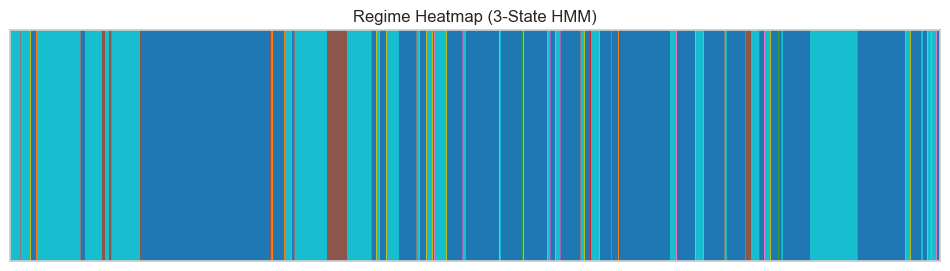

In [19]:
plt.figure(figsize=(12, 3))
plt.imshow([sp500['HMM_3State']], aspect='auto', cmap='tab10')
plt.title('Regime Heatmap (3-State HMM)')
plt.yticks([])
plt.xticks([])
plt.show()


In [20]:
sp500['HMM_3State'].value_counts().sort_index()


HMM_3State
0    3771
1     239
2    2400
Name: count, dtype: int64

In [21]:
# --- Extract Transition Matrix ---
transition_matrix = pd.DataFrame(hmm3.transmat_,
                                 columns=[f'To State {i}' for i in range(hmm3.n_components)],
                                 index=[f'From State {i}' for i in range(hmm3.n_components)])

print("Transition Probability Matrix (3-State HMM):")
display(transition_matrix.round(4))


Transition Probability Matrix (3-State HMM):


,To State 0,To State 1,To State 2
From State 0,0.9847,0.0002,0.0151
From State 1,0.0000,0.9473,0.0527
From State 2,0.0226,0.0049,0.9725


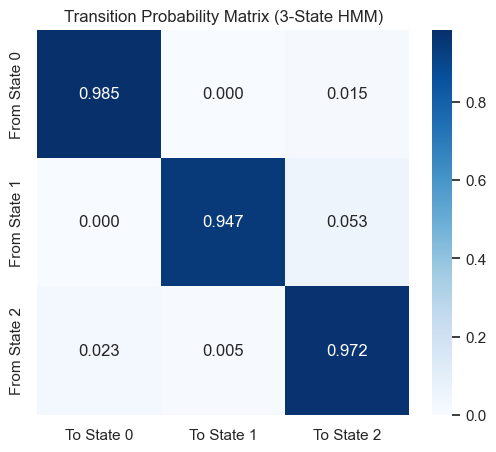

In [22]:
plt.figure(figsize=(6, 5))
sns.heatmap(transition_matrix, annot=True, fmt=".3f", cmap='Blues')
plt.title('Transition Probability Matrix (3-State HMM)')
plt.show()


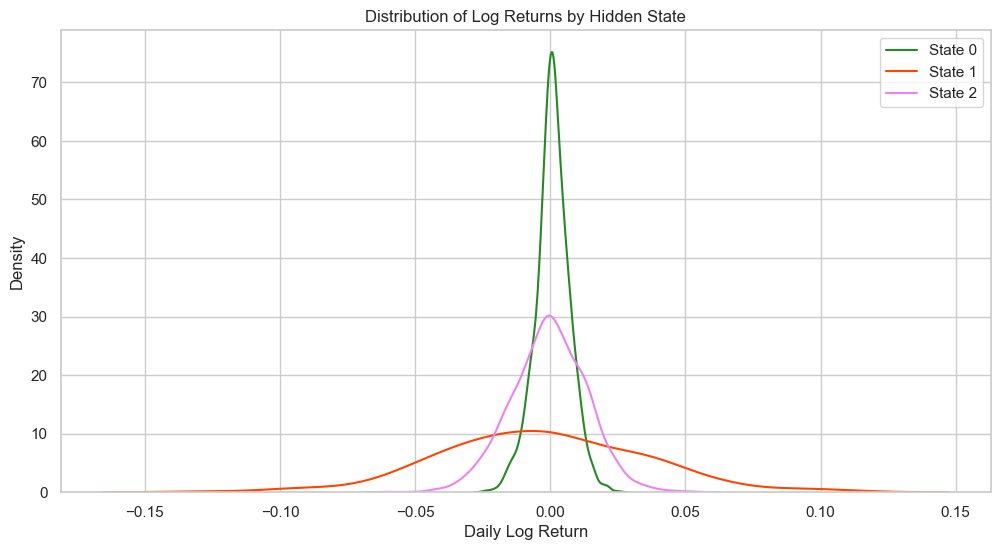

In [23]:
plt.figure(figsize=(12, 6))

for state in range(hmm3.n_components):
    sns.kdeplot(sp500['LogReturn'][sp500['HMM_3State'] == state], 
                label=f'State {state}', color=state_colors_3[state])

plt.title('Distribution of Log Returns by Hidden State')
plt.xlabel('Daily Log Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


## Weekly returns - 3-state HMM model

In [24]:
# --- Resample Close Prices to Weekly (Last available price of each week) ---
sp500_weekly = sp500['Close'].resample('W-FRI').last()

# --- Compute Weekly Log Returns ---
sp500_weekly = pd.DataFrame(sp500_weekly)
sp500_weekly['LogReturn'] = np.log(sp500_weekly['^GSPC']).diff()

# Drop NaNs from first diff
sp500_weekly.dropna(inplace=True)

sp500_weekly.head()


Ticker,^GSPC,LogReturn
Date,,
2000-01-14,1465.150024,0.016294
2000-01-21,1441.359985,-0.016371
2000-01-28,1360.160034,-0.057985
2000-02-04,1424.369995,0.046127
2000-02-11,1387.119995,-0.026500


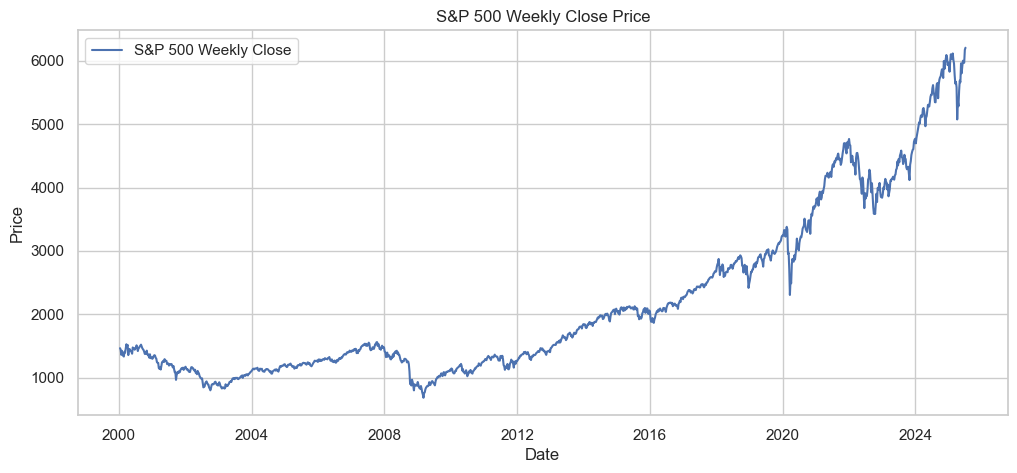

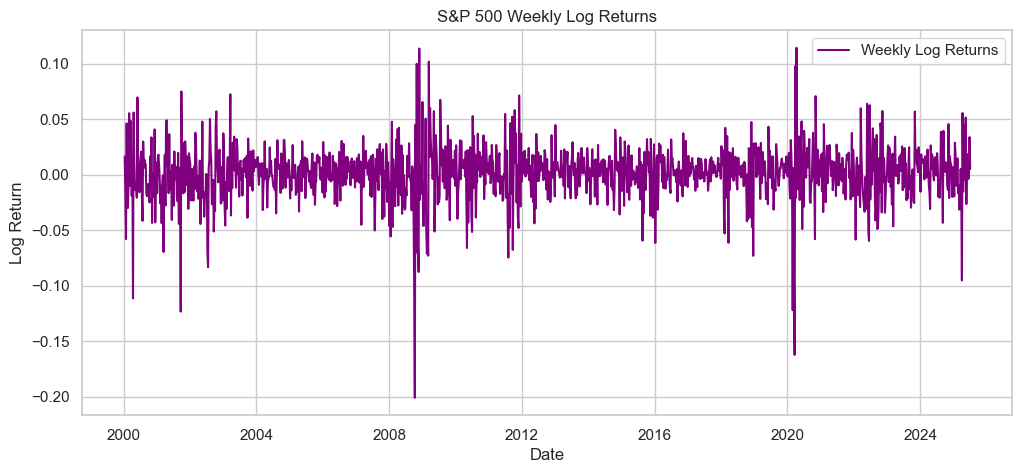

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(sp500_weekly['^GSPC'], label='S&P 500 Weekly Close')
plt.title('S&P 500 Weekly Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(sp500_weekly['LogReturn'], color='purple', label='Weekly Log Returns')
plt.title('S&P 500 Weekly Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.show()


In [26]:
# Reshape returns for HMM input
weekly_returns = sp500_weekly['LogReturn'].values.reshape(-1, 1)
# --- Fit the 3-State Gaussian HMM ---
hmm3_weekly = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=seed)
hmm3_weekly.fit(weekly_returns)

# --- Predict Hidden States ---
hidden_states_weekly = hmm3_weekly.predict(weekly_returns)

# --- Add Hidden States to DataFrame ---
sp500_weekly['HMM_3State'] = hidden_states_weekly

# --- Print Fitted Means & Variances ---
for i in range(hmm3_weekly.n_components):
    print(f"State {i}: Mean = {hmm3_weekly.means_[i][0]:.5f}, Variance = {hmm3_weekly.covars_[i][0][0]:.5f}")

print(f"Final log-likelihood (Weekly, 3-State): {hmm3_weekly.score(weekly_returns):.2f}")

State 0: Mean = 0.00291, Variance = 0.00025
State 1: Mean = 0.01325, Variance = 0.00133
State 2: Mean = -0.01977, Variance = 0.00164
Final log-likelihood (Weekly, 3-State): 3230.68


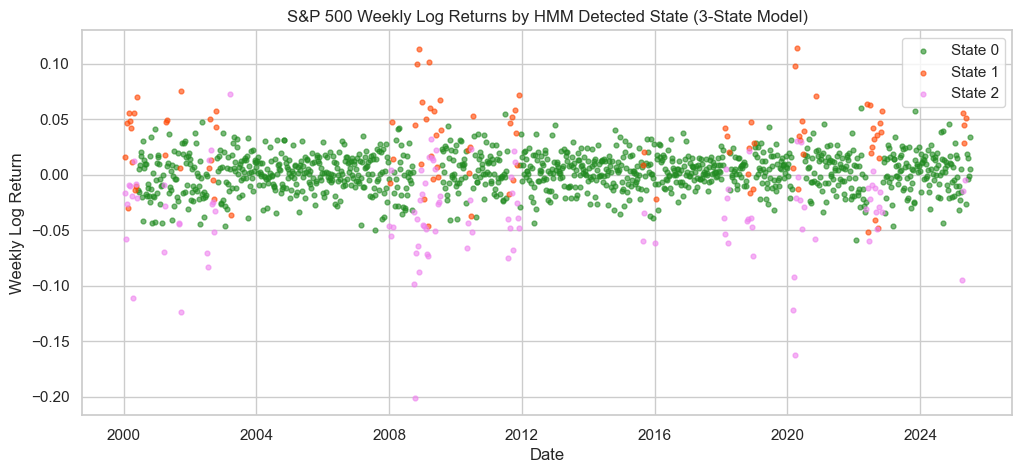

In [27]:
# Colour-coded scatter plot
plt.figure(figsize=(12, 5))

for state in range(hmm3_weekly.n_components):
    idx = sp500_weekly['HMM_3State'] == state
    plt.scatter(sp500_weekly.index[idx], sp500_weekly['LogReturn'][idx], 
                s=12, color=state_colors_3[state], label=f'State {state}', alpha = 0.6)

plt.title('S&P 500 Weekly Log Returns by HMM Detected State (3-State Model)')
plt.xlabel('Date')
plt.ylabel('Weekly Log Return')
plt.legend()
plt.grid(True)
plt.show()


Transition Probability Matrix (Weekly 3-State HMM):


,To State 0,To State 1,To State 2
From State 0,0.9746,0.0000,0.0254
From State 1,0.1628,0.2547,0.5825
From State 2,0.0025,0.6549,0.3427


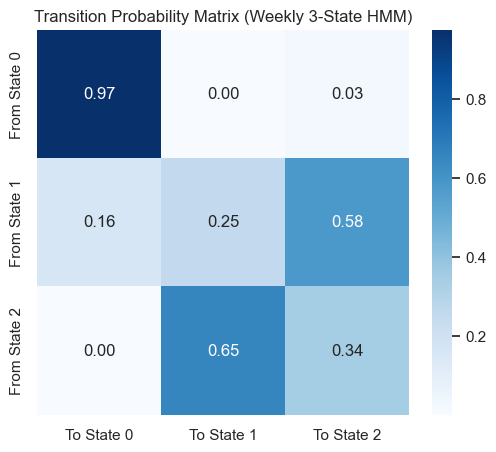

In [28]:
# --- Transition Matrix ---
transition_matrix_weekly = pd.DataFrame(hmm3_weekly.transmat_,
                                        columns=[f'To State {i}' for i in range(hmm3_weekly.n_components)],
                                        index=[f'From State {i}' for i in range(hmm3_weekly.n_components)])

print("Transition Probability Matrix (Weekly 3-State HMM):")
display(transition_matrix_weekly.round(4))

# --- Heatmap ---
plt.figure(figsize=(6, 5))
sns.heatmap(transition_matrix_weekly, annot=True, fmt=".2f", cmap='Blues')
plt.title('Transition Probability Matrix (Weekly 3-State HMM)')
plt.show()


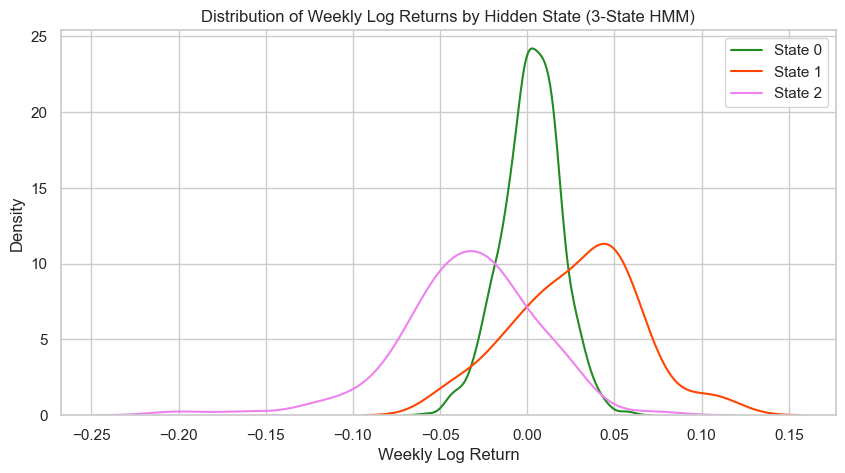

In [29]:
plt.figure(figsize=(10, 5))

for state in range(hmm3_weekly.n_components):
    sns.kdeplot(sp500_weekly['LogReturn'][sp500_weekly['HMM_3State'] == state], 
                label=f'State {state}', color=state_colors_3[state])

plt.title('Distribution of Weekly Log Returns by Hidden State (3-State HMM)')
plt.xlabel('Weekly Log Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


| State                | Colour | Shape                         | Interpretation                                              |
| -------------------- | ------ | ----------------------------- | ----------------------------------------------------------- |
| **State 0 (Green)**  | Green  | Narrow, centred near 0        | Calm regime, low volatility, stable returns                |
| **State 1 (Orange)** | Orange | Slightly wider, positive mean | Speculative or bullish regime — higher returns, higher risk |
| **State 2 (Purple)** | Purple | Left-skewed, fat-tailed       | Crisis regime, negative returns, large drawdowns           |


# Regime Summary table

-> Weekly observations

In [30]:
# Prepare a DataFrame to collect summary
summary_data = []

# Loop over each state
for state in range(hmm3_weekly.n_components):
    state_data = sp500_weekly[sp500_weekly['HMM_3State'] == state]['LogReturn']
    summary_data.append({
        'State': state,
        'Mean Return': state_data.mean(),
        'Volatility (Std Dev)': state_data.std(),
        'Observations': len(state_data)
    })

# Create summary DataFrame
regime_summary = pd.DataFrame(summary_data).set_index('State')

# Display formatted summary
regime_summary.style.format({
    'Mean Return': "{:.4%}",
    'Volatility (Std Dev)': "{:.4%}",
    'Observations': "{:,.0f}"
})


,Mean Return,Volatility (Std Dev),Observations
State,,,
0,0.2251%,1.6915%,"1,120"
1,2.8134%,3.5432%,98
2,-3.4096%,3.9789%,112


-> Daily observations

In [31]:
# Prepare summary data for daily 3-state model
summary_data_daily = []

for state in range(hmm3.n_components):
    state_data = sp500[sp500['HMM_3State'] == state]['LogReturn']
    summary_data_daily.append({
        'State': state,
        'Mean Return': state_data.mean(),
        'Volatility (Std Dev)': state_data.std(),
        'Observations': len(state_data)
    })

# Create DataFrame
regime_summary_daily = pd.DataFrame(summary_data_daily).set_index('State')

# Display with formatted style
regime_summary_daily.style.format({
    'Mean Return': "{:.4%}",
    'Volatility (Std Dev)': "{:.4%}",
    'Observations': "{:,.0f}"
})


,Mean Return,Volatility (Std Dev),Observations
State,,,
0,0.0883%,0.6419%,"3,771"
1,-0.3125%,3.7672%,239
2,-0.0471%,1.4010%,"2,400"


| Aspect             | Weekly                       | Daily                               |
| ------------------ | ---------------------------- | ----------------------------------- |
| Regime Separation  | Clearer                      | More mixed                          |
| Crisis Persistence | Rare but impactful           | Occasional clusters                 |
| Return Dispersion  | Broader                      | Tighter (except crisis)             |
| Strategic Insight  | Good for medium-term signals | Good for short-term risk management |


Takeaway:
* Weekly Model captures broader economic cycles, suitable for tactical asset allocation
* Daily Model may better reflect short-term volatility spikes but risks more false signals

# Overlay regimes on price data

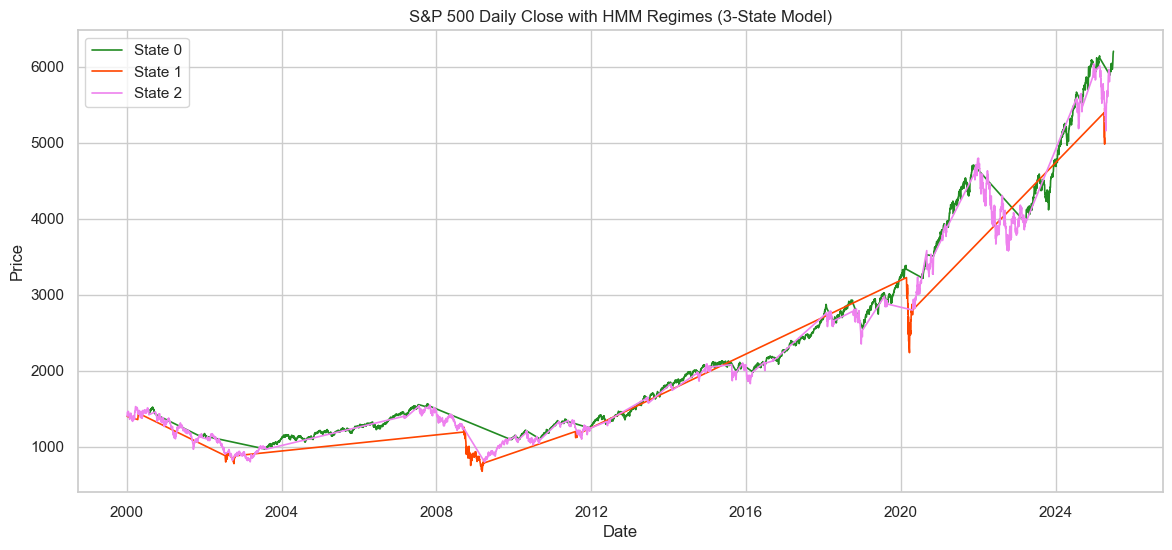

In [32]:
plt.figure(figsize=(14, 6))

for state in range(hmm3.n_components):
    idx = sp500['HMM_3State'] == state
    plt.plot(sp500.index[idx], sp500['Close'][idx], 
             color=state_colors_3[state], linewidth=1.2, label=f'State {state}')

plt.title('S&P 500 Daily Close with HMM Regimes (3-State Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


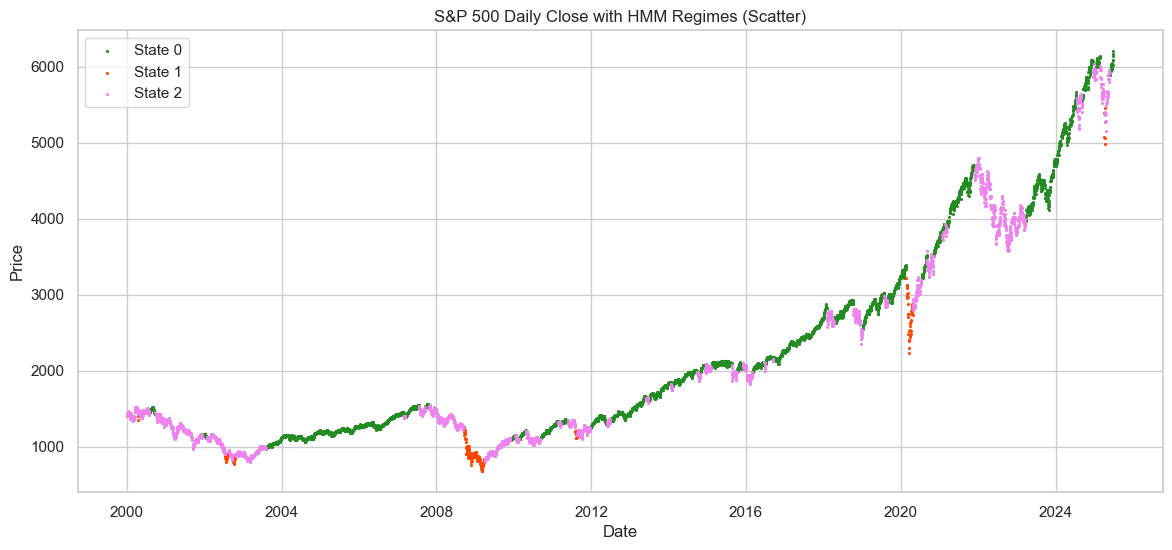

In [33]:
plt.figure(figsize=(14, 6))


for state in range(hmm3.n_components):
    idx = sp500['HMM_3State'] == state
    plt.scatter(sp500.index[idx], sp500['Close'][idx], 
                color=state_colors_3[state], s=1.5, label=f'State {state}')

plt.title('S&P 500 Daily Close with HMM Regimes (Scatter)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


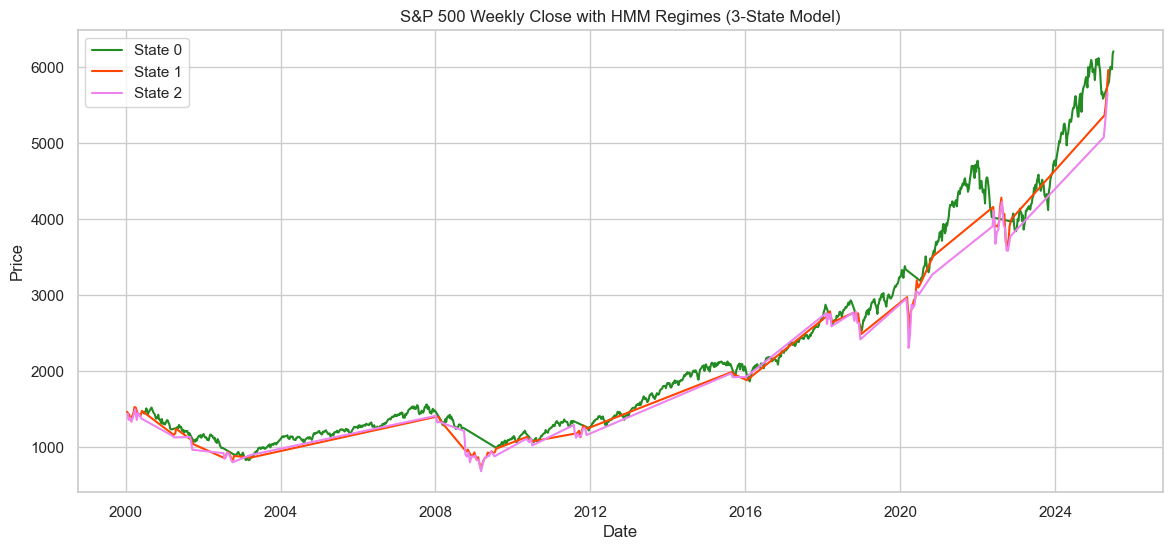

In [34]:
plt.figure(figsize=(14, 6))

for state in range(hmm3_weekly.n_components):
    idx = sp500_weekly['HMM_3State'] == state
    plt.plot(sp500_weekly.index[idx], sp500_weekly['^GSPC'][idx], 
             color=state_colors_3[state], linewidth=1.5, label=f'State {state}')

plt.title('S&P 500 Weekly Close with HMM Regimes (3-State Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


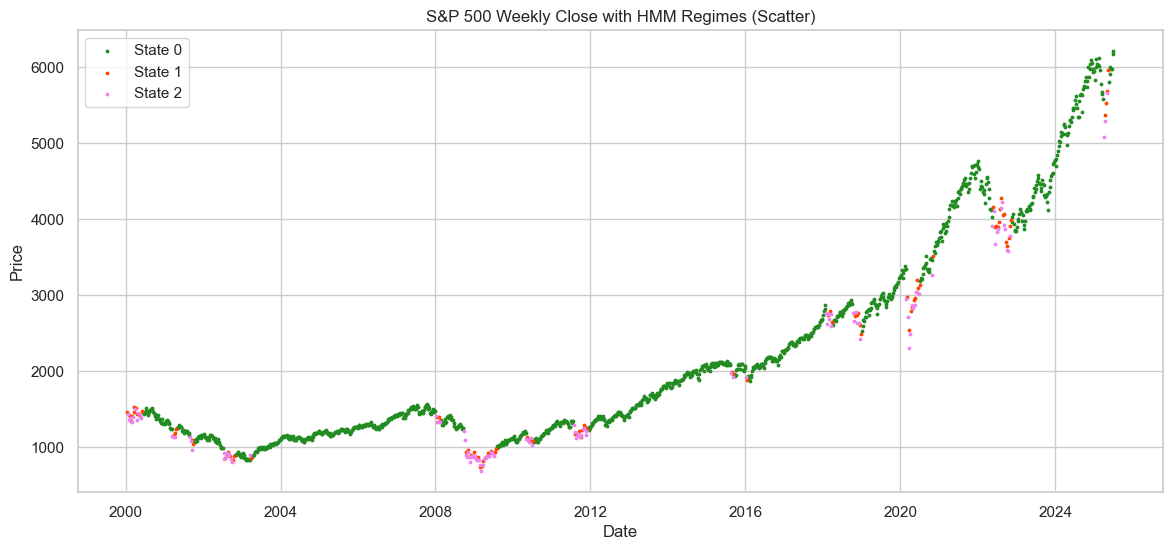

In [35]:
plt.figure(figsize=(14, 6))


for state in range(hmm3.n_components):
    idx = sp500_weekly['HMM_3State'] == state
    plt.scatter(sp500_weekly.index[idx], sp500_weekly['^GSPC'][idx], 
                color=state_colors_3[state], s=3, label=f'State {state}')

plt.title('S&P 500 Weekly Close with HMM Regimes (Scatter)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# Backtesting a simple Regime-Base Strategy

## Strategy 1

Daily Model:

✅ Long the market when in State 0 (calm regime)

🚫 Stay out (or in cash) when in other states

✅ Strategy 1: HMM Regime-Based Long-Only
Rule:

* ✅ Enter the market (long) only when the model detects State 0

* ❌ Stay in cash (0 return) when in any other state

Rationale:

* State 0 represents calm or bullish markets, based on our summary

* By avoiding volatile or crisis states, we aim to capture upside with reduced drawdowns

✅ Strategy 2: Benchmark - Buy & Hold
Rule:

* ✅ Always fully invested

* Ignore any regime or volatility signal

Rationale:

* Reflects a passive investor approach

* Serves as a baseline for comparing the active regime-based strategy

In [36]:
# Create a signal: 1 if in State 0, else 0 (you can test other states too)
sp500['Strategy_Signal'] = (sp500['HMM_3State'] == 0).astype(int)

# Calculate daily strategy returns (signal * daily return)
sp500['Strategy_Returns'] = sp500['Strategy_Signal'] * sp500['LogReturn']

# Buy & Hold returns for comparison
sp500['Market_Returns'] = sp500['LogReturn']


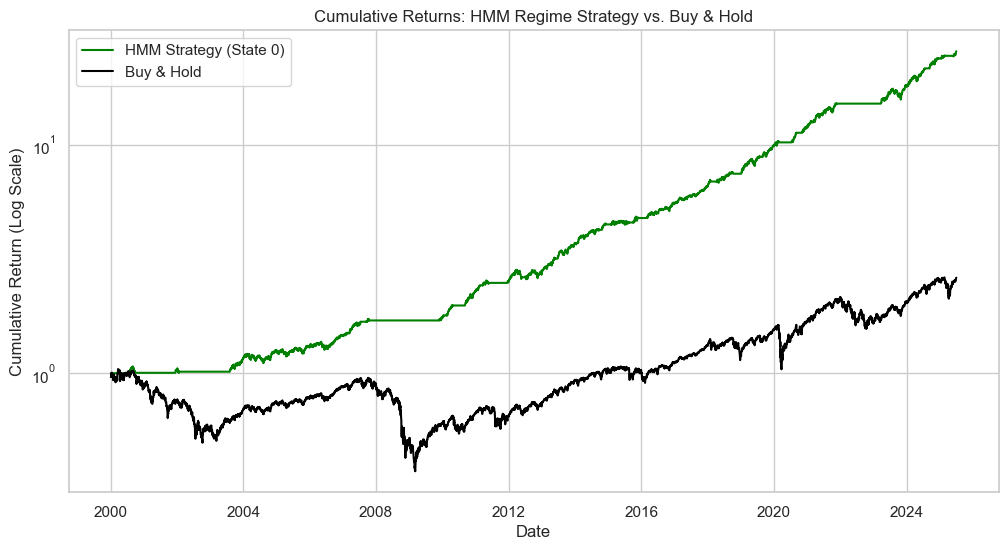

In [37]:
plt.figure(figsize=(12, 6))

# Strategy cumulative returns
plt.plot((sp500['Strategy_Returns'] + 1).cumprod(), label='HMM Strategy (State 0)', color='green')

# Market cumulative returns
plt.plot((sp500['Market_Returns'] + 1).cumprod(), label='Buy & Hold', color='black')

plt.title('Cumulative Returns: HMM Regime Strategy vs. Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Log Scale)')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()


In [38]:
strategy_cum_return = (sp500['Strategy_Returns'] + 1).prod() - 1
market_cum_return = (sp500['Market_Returns'] + 1).prod() - 1

print(f"HMM Strategy Cumulative Return: {strategy_cum_return:.2%}")
print(f"Buy & Hold Cumulative Return: {market_cum_return:.2%}")


HMM Strategy Cumulative Return: 2477.16%
Buy & Hold Cumulative Return: 162.13%


## Strategy 2

In [39]:
# Signal: Long only when in State 0 (weekly data)
sp500_weekly['Strategy_Signal'] = (sp500_weekly['HMM_3State'] == 0).astype(int)

# Strategy returns (signal * weekly return)
sp500_weekly['Strategy_Returns'] = sp500_weekly['Strategy_Signal'] * sp500_weekly['LogReturn']

# Buy & Hold returns (weekly)
sp500_weekly['Market_Returns'] = sp500_weekly['LogReturn']


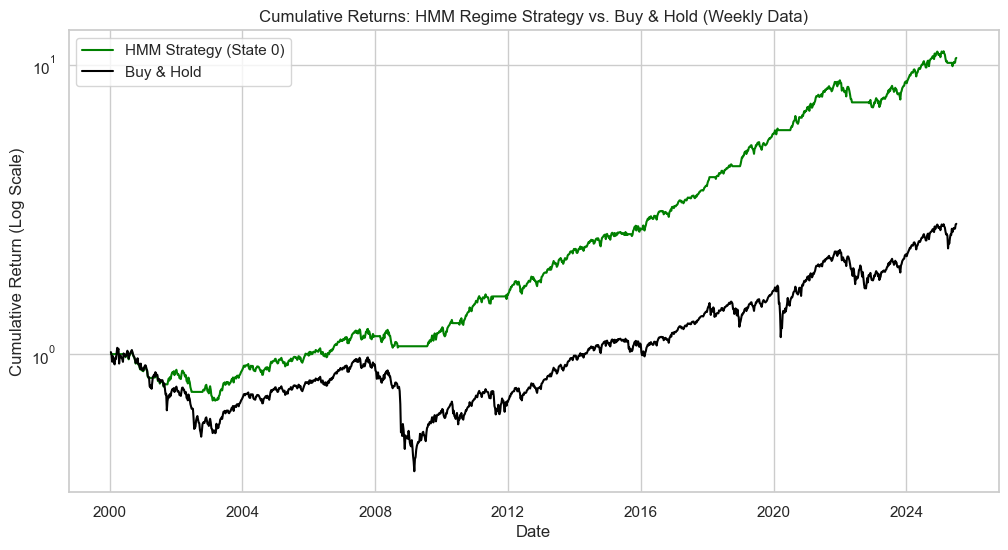

In [40]:
plt.figure(figsize=(12, 6))

plt.plot((sp500_weekly['Strategy_Returns'] + 1).cumprod(), label='HMM Strategy (State 0)', color='green')
plt.plot((sp500_weekly['Market_Returns'] + 1).cumprod(), label='Buy & Hold', color='black')

plt.title('Cumulative Returns: HMM Regime Strategy vs. Buy & Hold (Weekly Data)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Log Scale)')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()


In [41]:
strategy_cum_return_weekly = (sp500_weekly['Strategy_Returns'] + 1).prod() - 1
market_cum_return_weekly = (sp500_weekly['Market_Returns'] + 1).prod() - 1

print(f"HMM Strategy Cumulative Return (Weekly): {strategy_cum_return_weekly:.2%}")
print(f"Buy & Hold Cumulative Return (Weekly): {market_cum_return_weekly:.2%}")


HMM Strategy Cumulative Return (Weekly): 957.74%
Buy & Hold Cumulative Return (Weekly): 182.26%


## More thorough assessment

4 strategies assessed in daily and weekly

In [42]:
def compute_performance_with_sortino(series, periods_per_year):
    cumulative_return = (series + 1).prod() - 1
    annualised_return = (series + 1).prod()**(periods_per_year / len(series)) - 1
    annualised_vol = series.std() * np.sqrt(periods_per_year)
    sharpe = annualised_return / annualised_vol if annualised_vol != 0 else np.nan
    
    # Downside deviation (Sortino)
    downside_returns = series[series < 0]
    downside_vol = downside_returns.std() * np.sqrt(periods_per_year)
    sortino = annualised_return / downside_vol if downside_vol != 0 else np.nan
    
    # Max Drawdown
    running_max = (series.cumsum()).cummax()
    drawdown = (series.cumsum() - running_max)
    max_dd = drawdown.min()
    
    return cumulative_return, annualised_return, annualised_vol, sharpe, sortino, max_dd


### Daily

In [43]:
# Strategy Signals — Daily
sp500['Strat_Only_State0'] = (sp500['HMM_3State'] == 0).astype(int)
sp500['Strat_State0_or_1'] = sp500['HMM_3State'].isin([0, 1]).astype(int)
sp500['Strat_BuyHold'] = 1
sp500['Strat_Dynamic'] = sp500['HMM_3State'].map({0: 1.0, 1: 0.5, 2: 0.0})

# Apply to returns
sp500['Ret_Only_State0'] = sp500['Strat_Only_State0'] * sp500['LogReturn']
sp500['Ret_State0_or_1'] = sp500['Strat_State0_or_1'] * sp500['LogReturn']
sp500['Ret_BuyHold'] = sp500['Strat_BuyHold'] * sp500['LogReturn']
sp500['Ret_Dynamic'] = sp500['Strat_Dynamic'] * sp500['LogReturn']


In [44]:
results_daily = []
for col in ['Ret_Only_State0', 'Ret_State0_or_1', 'Ret_Dynamic', 'Ret_BuyHold']:
    metrics = compute_performance_with_sortino(sp500[col].dropna(), periods_per_year=252)
    results_daily.append({'Strategy': col, **dict(zip(['Cumulative Return', 'Annualised Return', 
                                                       'Annualised Volatility', 'Sharpe Ratio', 
                                                       'Sortino Ratio', 'Max Drawdown'], metrics))})

results_daily_df = pd.DataFrame(results_daily).set_index('Strategy')


In [45]:
results_daily_df

,Cumulative Return,Annualised Return,Annualised Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
Strategy,,,,,,
Ret_Only_State0,24.771649,0.136258,0.078454,1.736802,2.024788,-0.108439
Ret_State0_or_1,9.289445,0.095975,0.139837,0.686336,0.599755,-0.631428
Ret_Dynamic,16.000201,0.117824,0.097532,1.208061,1.270988,-0.323788
Ret_BuyHold,1.621281,0.038612,0.195237,0.197769,0.245673,-0.838760


| Strategy             | Cumulative Return | Annualised Return | Annualised Volatility | Sharpe Ratio | Sortino Ratio | Max Drawdown |
| -------------------- | ----------------- | ----------------- | --------------------- | ------------ | ------------- | ------------ |
| **Only State 0**     | 24.77%            | 13.63%            | 7.85%                 | **1.74**     | **2.02**      | **-10.84%**  |
| **State 0 or 1**     | 9.29%             | 9.60%             | 13.99%                | 0.69         | 0.60          | -63.14%      |
| **Dynamic Exposure** | 16.00%            | 11.78%            | 9.75%                 | 1.21         | 1.27          | -32.38%      |
| **Buy & Hold**       | 1.62%             | 3.86%             | 19.52%                | 0.20         | 0.25          | -83.88%      |


### Weekly

In [46]:
# Strategy Signals — Weekly
sp500_weekly['Strat_Only_State0'] = (sp500_weekly['HMM_3State'] == 0).astype(int)
sp500_weekly['Strat_State0_or_1'] = sp500_weekly['HMM_3State'].isin([0, 1]).astype(int)
sp500_weekly['Strat_BuyHold'] = 1
sp500_weekly['Strat_Dynamic'] = sp500_weekly['HMM_3State'].map({0: 1.0, 1: 0.5, 2: 0.0})

# Apply to returns
sp500_weekly['Ret_Only_State0'] = sp500_weekly['Strat_Only_State0'] * sp500_weekly['LogReturn']
sp500_weekly['Ret_State0_or_1'] = sp500_weekly['Strat_State0_or_1'] * sp500_weekly['LogReturn']
sp500_weekly['Ret_BuyHold'] = sp500_weekly['Strat_BuyHold'] * sp500_weekly['LogReturn']
sp500_weekly['Ret_Dynamic'] = sp500_weekly['Strat_Dynamic'] * sp500_weekly['LogReturn']


In [47]:
results_weekly = []
for col in ['Ret_Only_State0', 'Ret_State0_or_1', 'Ret_Dynamic', 'Ret_BuyHold']:
    metrics = compute_performance_with_sortino(sp500_weekly[col].dropna(), periods_per_year=52)
    results_weekly.append({'Strategy': col, **dict(zip(['Cumulative Return', 'Annualised Return', 
                                                       'Annualised Volatility', 'Sharpe Ratio', 
                                                       'Sortino Ratio', 'Max Drawdown'], metrics))})

results_weekly_df = pd.DataFrame(results_weekly).set_index('Strategy')


In [48]:
results_weekly_df

,Cumulative Return,Annualised Return,Annualised Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
Strategy,,,,,,
Ret_Only_State0,9.577359,0.096607,0.112080,0.861945,1.226527,-0.373219
Ret_State0_or_1,150.404418,0.216854,0.140460,1.543882,2.663521,-0.209426
Ret_Dynamic,39.970091,0.156229,0.119379,1.308677,2.003300,-0.219566
Ret_BuyHold,1.822561,0.041404,0.180157,0.229821,0.280482,-0.826543


| Strategy             | Cumulative Return | Annualised Return | Annualised Volatility | Sharpe Ratio | Sortino Ratio | Max Drawdown |
| -------------------- | ----------------- | ----------------- | --------------------- | ------------ | ------------- | ------------ |
| **Only State 0**     | 9.58%             | 9.67%             | 11.21%                | 0.86         | 1.23          | -37.32%      |
| **State 0 or 1**     | 150.44%           | 21.69%            | 14.06%                | **1.54**     | **2.66**      | **-20.94%**  |
| **Dynamic Exposure** | 39.97%            | 15.63%            | 11.94%                | 1.31         | 2.00          | -21.96%      |
| **Buy & Hold**       | 1.82%             | 4.14%             | 18.02%                | 0.23         | 0.28          | -82.65%      |


In [49]:
sp500_weekly.columns

Index(['^GSPC', 'LogReturn', 'HMM_3State', 'Strategy_Signal',
       'Strategy_Returns', 'Market_Returns', 'Strat_Only_State0',
       'Strat_State0_or_1', 'Strat_BuyHold', 'Strat_Dynamic',
       'Ret_Only_State0', 'Ret_State0_or_1', 'Ret_BuyHold', 'Ret_Dynamic'],
      dtype='object', name='Ticker')

In [50]:
# Define your strategy columns
strategy_cols = ['Ret_Only_State0', 'Ret_State0_or_1', 'Ret_Dynamic', 'Ret_BuyHold']

# Monthly cumulative returns (resample and compound)
monthly_returns = sp500_weekly[strategy_cols].resample('M').apply(lambda x: (x + 1).prod() - 1)

# Yearly cumulative returns
yearly_returns = sp500_weekly[strategy_cols].resample('Y').apply(lambda x: (x + 1).prod() - 1)


In [51]:
# Monthly summary
monthly_summary = monthly_returns.describe().T

# Yearly summary
yearly_summary = yearly_returns.describe().T


monthly_summary.round(4)


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
Ret_Only_State0,307.0,0.0082,0.0307,-0.0917,-0.0084,0.0076,0.0304,0.1052
Ret_State0_or_1,307.0,0.0173,0.0403,-0.0917,-0.0080,0.0146,0.0370,0.1677
Ret_Dynamic,307.0,0.0127,0.0329,-0.0917,-0.0058,0.0140,0.0340,0.1052
Ret_BuyHold,307.0,0.0045,0.0473,-0.2304,-0.0199,0.0109,0.0332,0.1329


In [52]:
yearly_summary.round(4)

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
Ret_Only_State0,26.0,0.1039,0.1388,-0.1942,0.0271,0.1289,0.1979,0.3058
Ret_State0_or_1,26.0,0.2261,0.1960,-0.0391,0.1124,0.1847,0.2907,0.8434
Ret_Dynamic,26.0,0.1614,0.1384,-0.1024,0.0657,0.1460,0.2546,0.4919
Ret_BuyHold,26.0,0.0590,0.1863,-0.4459,-0.0227,0.0918,0.2212,0.3058


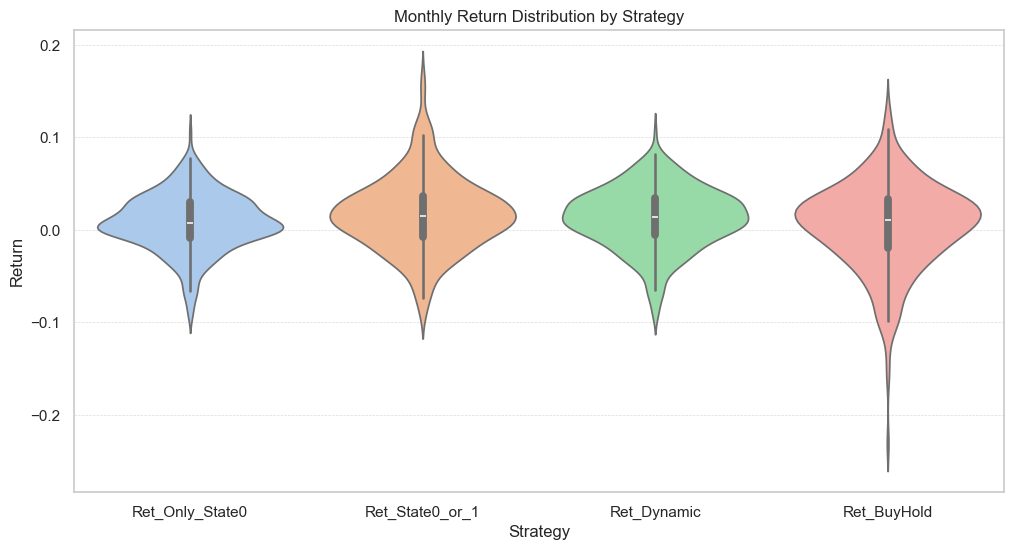

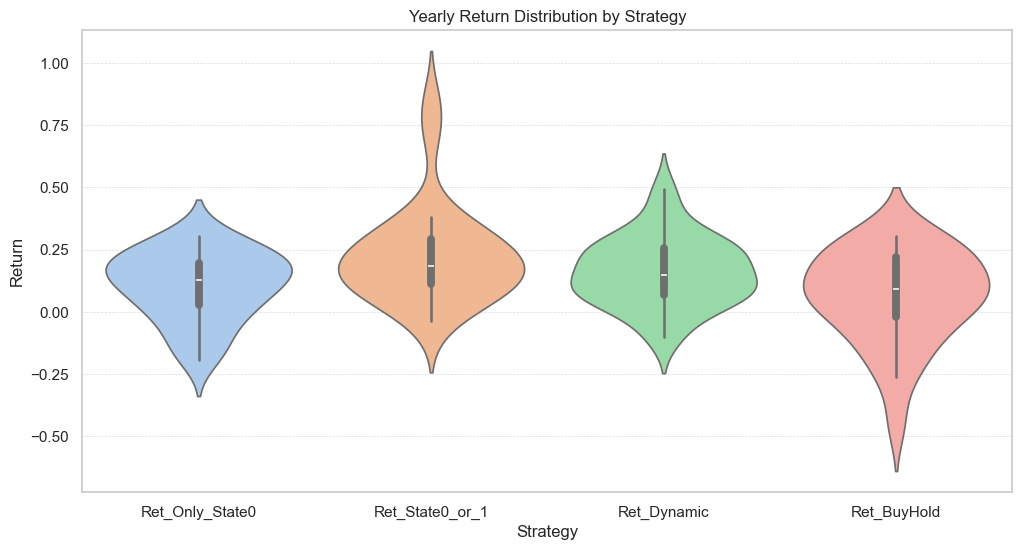

In [53]:

# Set a pastel style
sns.set(style="whitegrid", palette="pastel")

# Melt data for Seaborn
monthly_melted = monthly_returns.reset_index().melt(id_vars='Date', var_name='Strategy', value_name='Return')
yearly_melted = yearly_returns.reset_index().melt(id_vars='Date', var_name='Strategy', value_name='Return')

# Monthly Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=monthly_melted, x='Strategy', y='Return', inner='box', palette='pastel')
plt.title('Monthly Return Distribution by Strategy')
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

# Yearly Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=yearly_melted, x='Strategy', y='Return', inner='box', palette='pastel')
plt.title('Yearly Return Distribution by Strategy')
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [54]:
from datetime import datetime, timedelta

# Get latest date in dataset
latest_date = sp500_weekly.index.max()

# Define cutoffs
cutoffs = {
    '5Y': latest_date - pd.DateOffset(years=5),
    '3Y': latest_date - pd.DateOffset(years=3),
    '1Y': latest_date - pd.DateOffset(years=1)
}


In [55]:
def compute_annualised_metrics(df, periods_per_year=52):
    metrics = {}
    for strat in df.columns:
        series = df[strat].dropna()
        cumulative_return = (series + 1).prod() - 1
        annualised_return = (series + 1).prod() ** (periods_per_year / len(series)) - 1
        annualised_vol = series.std() * np.sqrt(periods_per_year)
        sharpe = annualised_return / annualised_vol if annualised_vol != 0 else np.nan
        metrics[strat] = {
            'Cumulative Return': cumulative_return,
            'Annualised Return': annualised_return,
            'Annualised Volatility': annualised_vol,
            'Sharpe Ratio': sharpe
        }
    return pd.DataFrame(metrics).T


In [56]:
results = {}

for label, cutoff in cutoffs.items():
    df_window = sp500_weekly.loc[cutoff:][['Ret_Only_State0', 'Ret_State0_or_1', 'Ret_Dynamic', 'Ret_BuyHold']]
    results[label] = compute_annualised_metrics(df_window)

# Example: display 5-year results
results['5Y'].style.format('{:.2%}')


,Cumulative Return,Annualised Return,Annualised Volatility,Sharpe Ratio
Ret_Only_State0,77.74%,12.14%,12.36%,98.21%
Ret_State0_or_1,201.42%,24.59%,15.04%,163.49%
Ret_Dynamic,132.59%,18.31%,13.03%,140.52%
Ret_BuyHold,84.65%,13.00%,16.75%,77.58%


In [57]:
# Combine into a single DataFrame with MultiIndex
combined_results = pd.concat(results, axis=0)
combined_results.index.names = ['Horizon', 'Strategy']

# Display nicely
combined_results.style.format('{:.2%}')


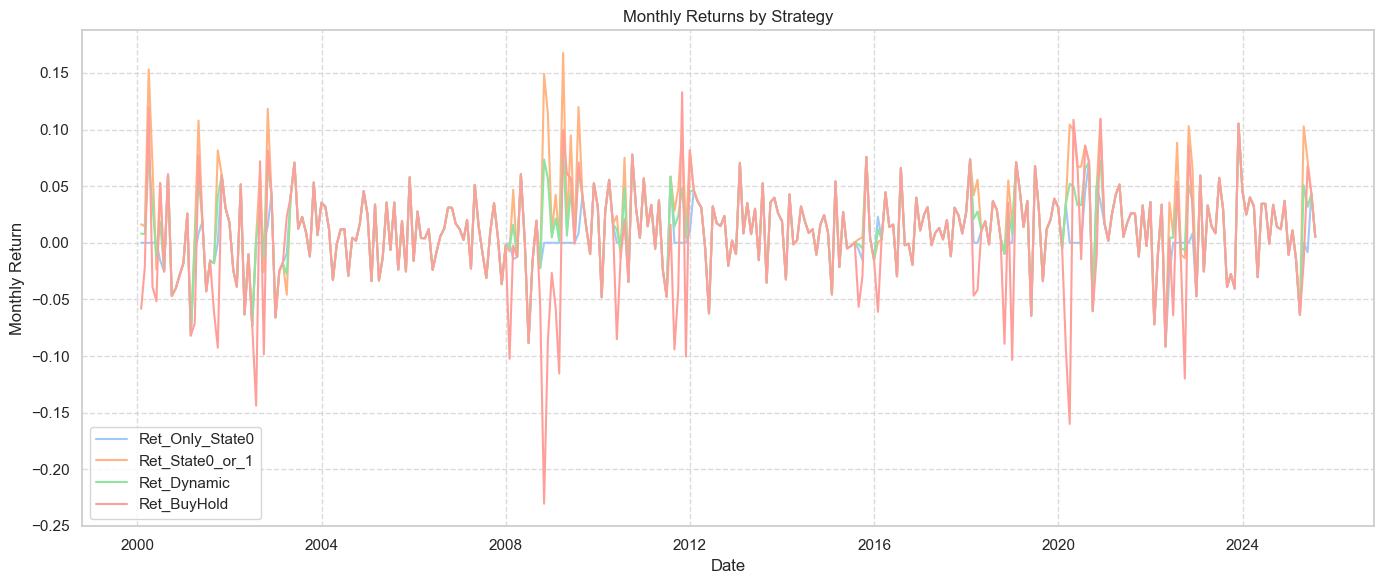

In [58]:
# Resample to Monthly Returns (non-cumulative, period returns)
monthly_returns = sp500_weekly[['Ret_Only_State0', 'Ret_State0_or_1', 'Ret_Dynamic', 'Ret_BuyHold']].resample('M').apply(lambda x: (x + 1).prod() - 1)

# Resample to Yearly Returns
yearly_returns = sp500_weekly[['Ret_Only_State0', 'Ret_State0_or_1', 'Ret_Dynamic', 'Ret_BuyHold']].resample('Y').apply(lambda x: (x + 1).prod() - 1)

# Example: Monthly Returns Plot
plt.figure(figsize=(14, 6))

for column in monthly_returns.columns:
    plt.plot(monthly_returns.index, monthly_returns[column], label=column)

plt.title('Monthly Returns by Strategy')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()



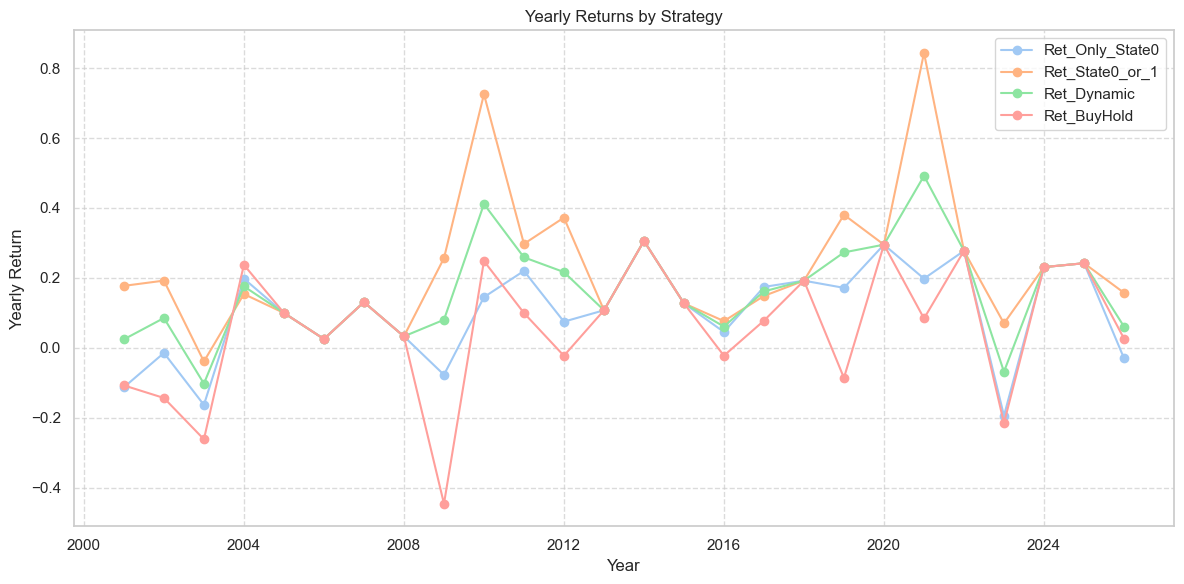

In [59]:
# Example: Yearly Returns Plot
plt.figure(figsize=(12, 6))

for column in yearly_returns.columns:
    plt.plot(yearly_returns.index, yearly_returns[column], marker='o', label=column)

plt.title('Yearly Returns by Strategy')
plt.xlabel('Year')
plt.ylabel('Yearly Return')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
yearly_returns

Ticker,Ret_Only_State0,Ret_State0_or_1,Ret_Dynamic,Ret_BuyHold
Date,,,,
2000-12-31,-0.112738,0.177266,0.024327,-0.107543
2001-12-31,-0.014594,0.192227,0.085254,-0.143491
2002-12-31,-0.163274,-0.039058,-0.102429,-0.261627
2003-12-31,0.197860,0.153884,0.175872,0.237366
2004-12-31,0.099633,0.099633,0.099633,0.099633
2005-12-31,0.025201,0.025201,0.025201,0.025201
2006-12-31,0.130690,0.130690,0.130690,0.130690
2007-12-31,0.032762,0.032762,0.032762,0.032762
2008-12-31,-0.077123,0.256427,0.080188,-0.445895


In [61]:
sp500_weekly['PredictedState'] = hmm3_weekly.predict(sp500_weekly[['LogReturn']])

In [62]:
# 1️⃣ Create a helper column to identify regime runs (change points)
sp500_weekly['StateChange'] = (sp500_weekly['PredictedState'] != sp500_weekly['PredictedState'].shift(1)).cumsum()

# 2️⃣ Group by regime runs and get duration
state_durations = sp500_weekly.groupby(['StateChange', 'PredictedState']).size().reset_index(name='Duration')

# 3️⃣ Compute Mean & Median Duration per State
duration_stats = state_durations.groupby('PredictedState')['Duration'].agg(['mean', 'median']).round(2)

print(duration_stats)

                 mean  median
PredictedState               
0               65.88    40.0
1                1.08     1.0
2                1.24     1.0


# Final results

🕒 Daily Model (Higher Frequency, More Volatility Sensitivity)
| Strategy             | Annual Return | Sharpe   | Sortino  | Max Drawdown |
| -------------------- | ------------- | -------- | -------- | ------------ |
| **Only State 0**     | **13.63%**    | **1.74** | **2.02** | **-10.84%**  |
| **State 0 or 1**     | 9.60%         | 0.69     | 0.60     | -63.14%      |
| **Dynamic Exposure** | 11.78%        | 1.21     | 1.27     | -32.38%      |
| **Buy & Hold**       | 3.86%         | 0.20     | 0.25     | -83.88%      |


✅ Key Takeaways (Daily):
* State 0 only strategy dominates for risk-adjusted returns
* Dynamic exposure offers a reasonable balance
* Including State 1 on daily data hurts performance — too noisy, high drawdowns
* ❗ Buy & Hold severely underperforms in both return and risk

📅 Weekly Model (Smoother Regimes, Clearer Market Phases)
| Strategy             | Annual Return | Sharpe   | Sortino  | Max Drawdown |
| -------------------- | ------------- | -------- | -------- | ------------ |
| **Only State 0**     | 9.67%         | 0.86     | 1.23     | -37.32%      |
| **State 0 or 1**     | **21.69%**    | **1.54** | **2.66** | **-20.94%**  |
| **Dynamic Exposure** | 15.63%        | 1.31     | 2.00     | -21.96%      |
| **Buy & Hold**       | 4.14%         | 0.23     | 0.28     | -82.65%      |


✅ Key Takeaways (Weekly):
* State 0 or 1 strategy is the standout performer — good returns, acceptable risk
* Dynamic exposure again balances risk/reward effectively
* State 0 only is too conservative on weekly data, limiting upside
* ❗ Buy & Hold still has catastrophic drawdown

📝 **Interpretation Based on Regime Characteristics**
| Aspect                 | Daily Model                | Weekly Model                         |
| ---------------------- | -------------------------- | ------------------------------------ |
| **Regime Sensitivity** | Volatility clustering      | Market phase (calm, bullish, crisis) |
| **Best Strategy**      | Only State 0               | State 0 or 1                         |
| **Dynamic Strategy**   | Good compromise            | Very effective                       |
| **Including State 1**  | Risky, worsens risk/return | Works well on weekly                 |
| **Buy & Hold**         | Poor on both               | Poor on both                         |


✅ Summary:
* ✅ Daily Model shines when you want low volatility exposure with minimal drawdowns

* ✅ Weekly Model captures broader market phases, State 1 contributes positively when regimes persist

* ✅ Dynamic strategies work well across both frequencies

* ❗ Passive exposure (Buy & Hold) underperforms heavily in both cases

## Practical Guide

**Using Weekly HMM for Regime-Based Investing**

1️⃣ Model Purpose Recap:
The weekly HMM model classifies market conditions into three regimes:

* State 0 — Calm/Low Volatility (Neutral/Stable Phase)
* State 1 — Positive/High Momentum (Bullish/Speculative Phase)
* State 2 — Negative/High Risk (Crisis Phase)

2️⃣ Suggested Strategy:
| State           | Allocation                                | Rationale                               |
| --------------- | ----------------------------------------- | --------------------------------------- |
| **0 (Calm)**    | **100% Long Equities**                    | Historically best risk-adjusted returns |
| **1 (Bullish)** | **100% Long Equities**                    | Contributes meaningfully on weekly data |
| **2 (Crisis)**  | **0% Equities / Defensive Assets / Cash** | Avoided due to high drawdowns           |

3️⃣ Weekly Workflow:
1. Every Week (e.g., Friday Close):
* Update market data (e.g., S&P 500 weekly close)
* Calculate weekly log return
* Use your fitted HMM to predict current regime based on latest return
2. Based on Detected Regime:
* State 0 or 1: ✅ Stay invested in equities (or your risk asset)
* State 2: ❗ Shift to cash, bonds, or low-risk assets
3. Optional Enhancements:
* Dynamic Allocation:
    * 100% in State 0
    * 75% in State 1
    * 0% in State 2
4. Review Monthly/Quarterly:
* Monitor strategy performance
* Refit model yearly or if structural breaks occur

4️⃣ Practical Considerations:
* 🕗 Lag Effect: You act on last week's state, this works for medium-term risk management but is not suitable for daily trading
* 🧩 Position Sizing: Consider layering with volatility targeting for smoother exposure
* ⚖️ Diversification: Apply on an index level; results may differ on single stocks
* 📝 Documentation: Keep track of your decision logic for consistency


In [63]:
# 1️⃣ Download daily S&P 500 data
data = yf.download('^GSPC', start='2000-01-01', interval='1d')[['Close']]

# 2️⃣ Resample Close Prices to Weekly (Friday Close)
sp500_weekly = data.resample('W-FRI').last()

# 3️⃣ Compute Weekly Log Returns (on 'Close' column)
sp500_weekly['LogReturn'] = np.log(sp500_weekly['Close'] / sp500_weekly['Close'].shift(1))

# 4️⃣ Drop NaNs (from the first difference)
sp500_weekly.dropna(inplace=True)

# 5️⃣ Predict regimes with your trained model
sp500_weekly['PredictedState'] = hmm3_weekly.predict(sp500_weekly[['LogReturn']])

# 6️⃣ Display last 6 weeks
print(sp500_weekly.tail(12))

[*********************100%***********************]  1 of 1 completed

Price             Close LogReturn PredictedState
Ticker            ^GSPC                         
Date                                            
2025-05-09  5659.910156 -0.004717              2
2025-05-16  5958.379883  0.051391              1
2025-05-23  5802.819824 -0.026455              0
2025-05-30  5911.689941  0.018588              0
2025-06-06  6000.359863  0.014888              0
2025-06-13  5976.970215 -0.003906              0
2025-06-20  5967.839844 -0.001529              0
2025-06-27  6173.069824  0.033811              0
2025-07-04  6279.350098  0.017070              0
2025-07-11  6259.750000 -0.003126              0
2025-07-18  6296.790039  0.005900              0
2025-07-25  6388.640137  0.014481              0
